In [2]:
import math 
import time 

import torch 
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as trans

%matplotlib inline

BATCH_SIZE = 100
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# 加载数据
train_set = dsets.MNIST(root = './data',
                        train = True,
                        download = True,
                        transform = trans.ToTensor())
train_dl = torch.utils.data.DataLoader(dataset = train_set,
                                        batch_size = BATCH_SIZE,
                                        num_workers = 6)


## 定义自编码器
|模型|网络结构|
|:---:|:---:|
|编码器|784-1000-1000-2 $z_d$|
|解码器|$z_d$ 20-1000-1000-784|

In [7]:
class VAE(nn.Module):
    def __init__(self,z_dim):
        super(VAE,self).__init__()
        W = 1000
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28,W),
            nn.ReLU(),
            nn.Linear(W,W),
            nn.ReLU(),
            nn.Linear(W,2*z_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim,W),
            nn.ReLU(),
            nn.Linear(W,W),
            nn.ReLU(),
            nn.Linear(W,28*28),
            nn.Sigmoid()
        ) 
    def forward(self,x):
        o = self.encoder(x)
        mu,log_var = o[:,0:self.z_dim],o[:,self.z_dim:]
        
        eps = torch.randn_like(mu)
        z = mu + eps * torch.exp(log_var/2)
        
        x_rec = self.decoder(z)
        return x_rec,mu,log_var

In [8]:
def train_epoch(model,optimizer,dataloader):
    loss_avg = 0
    for x,_ in dataloader:
        x = x.view(-1,28*28).to(device)
             
        optimizer.zero_grad()
        x_rec,mu,log_var = model(x)
   
        loss_rec = F.mse_loss(x_rec,x,reduction='sum')
        kl_d = 0.5 * (mu.pow(2) + torch.exp(log_var) - log_var - 1).sum()
        loss_tot = (loss_rec + kl_d)/x.size(0)
        loss_tot.backward()
        optimizer.step()
        
        loss_avg += loss_tot
    
    return loss_avg/len(dataloader)

模型的实例化和优化器

In [9]:
z_dim = 40
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
nepoches = 40

开始训练

In [12]:
for epoch in range(nepoches):
    loss = train_epoch(model,optimizer,train_dl)
    print('%d/%d, %.2e' % (epoch+1, nepoches, loss))

1/40, 3.50e+01
2/40, 3.28e+01
3/40, 3.17e+01
4/40, 3.10e+01
5/40, 3.05e+01
6/40, 3.01e+01
7/40, 2.97e+01
8/40, 2.94e+01
9/40, 2.91e+01
10/40, 2.89e+01
11/40, 2.87e+01
12/40, 2.86e+01
13/40, 2.84e+01
14/40, 2.83e+01
15/40, 2.82e+01
16/40, 2.81e+01
17/40, 2.80e+01
18/40, 2.80e+01
19/40, 2.79e+01
20/40, 2.78e+01
21/40, 2.78e+01
22/40, 2.78e+01
23/40, 2.77e+01
24/40, 2.76e+01
25/40, 2.76e+01
26/40, 2.76e+01
27/40, 2.76e+01
28/40, 2.75e+01
29/40, 2.75e+01
30/40, 2.74e+01
31/40, 2.74e+01
32/40, 2.73e+01
33/40, 2.73e+01
34/40, 2.73e+01
35/40, 2.73e+01
36/40, 2.73e+01
37/40, 2.72e+01
38/40, 2.72e+01
39/40, 2.72e+01
40/40, 2.71e+01


In [13]:
z = torch.randn(100,z_dim).to(device)
x = model.decoder(z)
x = x.data.view(-1,1,28,28).cpu()

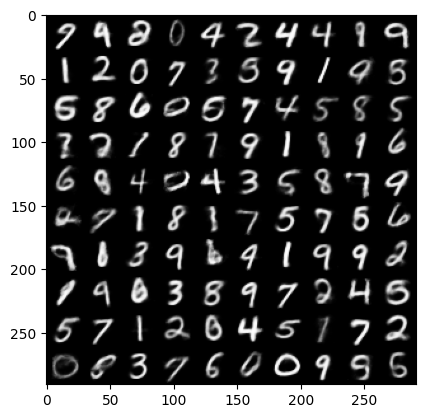

In [16]:
import matplotlib.pyplot as plt
import torchvision

X = torchvision.utils.make_grid(x,nrow=10,padding=1)
X = X.permute(1,2,0).numpy()
plt.imshow(X)

In [18]:
X = train_set.data[0:2]
X = X.unsqueeze(1).float()/255
X = X.view(-1,28*28).to(device)

e = model.encoder(X)
mu,log_var = e[:,0:z_dim],e[:,z_dim:]


In [19]:
t_s = torch.linspace(0,1,10)
x_s = []
for t in t_s:
    t =t.item()
    mu_cur = mu[0] * t + mu[1] * (1-t)
    log_var_cur = log_var[0] * t + log_var[1] * (1-t)
    
    eps = torch.randn_like(mu_cur)
    z = mu_cur + eps * torch.exp(log_var_cur/2)
    x_rec = model.decoder(z)
    
    x_s.append(x_rec)
    

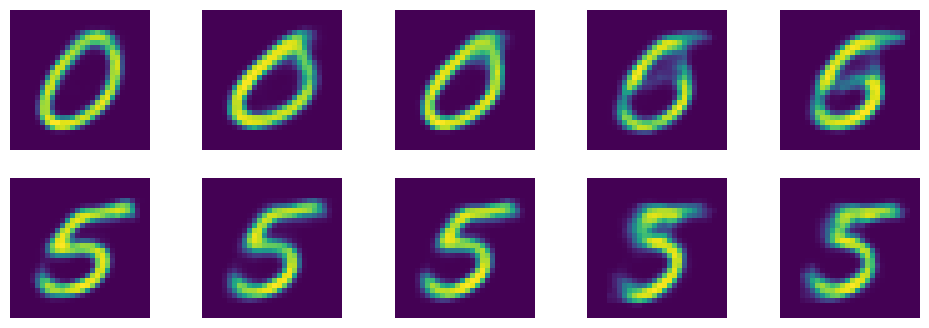

In [21]:
plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_s[i].view(28,28).data.cpu().numpy())
    plt.axis('off')